### Define input of problem

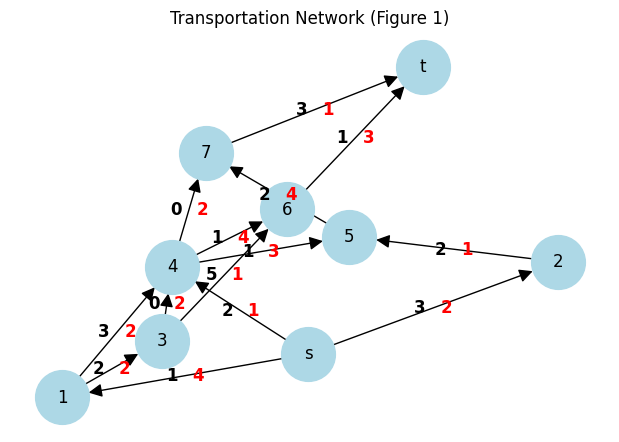

In [ ]:
import cvxpy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# Define the Transportation Network (Figure 1)
# -------------------------------

# Define the edges as tuples: (source, target, cost, capacity)
edges = [
    ("s", "1", 1, 4),
    ("s", "2", 3, 2),
    ("s", "4", 2, 1),
    ("1", "3", 2, 2),
    ("1", "4", 3, 2),
    ("2", "5", 2, 1),
    ("3", "4", 0, 2),
    ("3", "6", 5, 1),
    ("4", "5", 1, 3),
    ("4", "6", 1, 4),
    ("4", "7", 0, 2),
    ("5", "7", 2, 4),
    ("6", "t", 1, 3),
    ("7", "t", 3, 1)

]

# Create a directed graph using networkx
nodes = ["s", "1", "2", "3", "4", "5", "6", "7", "t"]
G = nx.DiGraph()
G.add_nodes_from(nodes)
for u, v, cost, cap in edges:
    G.add_edge(u, v, cost=cost, capacity=cap)

# Draw the graph (Figure 1)
pos = nx.spring_layout(G)
# Create edge labels in the form "cost/capacity"
edge_labels = {(u, v): f"{G[u][v]['cost']}/{G[u][v]['capacity']}" for u, v in G.edges()}
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=12, arrowsize=20)
delta = 0.02  # offset amount

for (u, v) in G.edges():
    # Compute the midpoint of the edge
    x_mid = (pos[u][0] + pos[v][0]) / 2.0
    y_mid = (pos[u][1] + pos[v][1]) / 2.0

    # Retrieve cost and capacity from the graph attributes
    edge_cost = G[u][v]['cost']
    edge_cap  = G[u][v]['capacity']

    # Plot cost (black) and capacity (red) with a slight horizontal offset
    plt.text(x_mid - delta, y_mid, f"{edge_cost}", color='black',
             fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
    plt.text(x_mid + delta, y_mid, f"{edge_cap}", color='red',
             fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.title("Transportation Network (Figure 1)")
plt.show()

### Define and Solve the LP for the Transportation Problem

In [ ]:
# -------------------------------
# Define and Solve the LP for the Transportation Problem
# -------------------------------

# Set required flow from source to sink
r = 2.5

# Build dictionaries mapping each node to its outgoing and incoming edge indices
node_out_edges = {node: [] for node in nodes}
node_in_edges = {node: [] for node in nodes}
for idx, (u, v, cost, cap) in enumerate(edges):
    node_out_edges[u].append(idx)
    node_in_edges[v].append(idx)

# Total number of edges
num_edges = len(edges)

# Decision variable: flow on each edge (nonnegative)
x = cp.Variable(num_edges, nonneg=True)

# Build the flow conservation constraints
# Define the equality constraints networl supply b: b[s] = r, b[t] = -r, and b[node] = 0 for all other nodes.
b = {node: 0 for node in nodes}
b["s"] = r
b["t"] = -r

constraints = []
for node in nodes:
    # Net flow = (sum of flows out) - (sum of flows in) should equal b[node]
    out_flow = cp.sum(x[node_out_edges[node]]) if node_out_edges[node] else 0
    in_flow = cp.sum(x[node_in_edges[node]]) if node_in_edges[node] else 0
    constraints.append(out_flow - in_flow == b[node])

# Add capacity constraints: for each edge, x[i] <= capacity
for idx, (u, v, cost, cap) in enumerate(edges):
    constraints.append(x[idx] <= cap)

# Define the objective: minimize total cost (sum of cost[i]*x[i] for each edge)
cost_vector = np.array([edge[2] for edge in edges], dtype=float)
objective = cp.Minimize(cost_vector @ x)

# Formulate and solve the problem
prob = cp.Problem(objective, constraints)
optimal_value = prob.solve()

# Display the results
print("Optimal total transportation cost:", prob.value)
print("Optimal flows on each edge:")
for idx, (u, v, cost, cap) in enumerate(edges):
    print(f"Edge ({u} -> {v}): Flow = {x.value[idx]:.2f}, Cost per unit = {cost}, Capacity = {cap}")


Optimal total transportation cost: 11.500000000171063
Optimal flows on each edge:
Edge (s -> 1): Flow = 1.50, Cost per unit = 1, Capacity = 4
Edge (s -> 2): Flow = 0.00, Cost per unit = 3, Capacity = 2
Edge (s -> 4): Flow = 1.00, Cost per unit = 2, Capacity = 1
Edge (1 -> 3): Flow = 1.50, Cost per unit = 2, Capacity = 2
Edge (1 -> 4): Flow = 0.00, Cost per unit = 3, Capacity = 2
Edge (2 -> 5): Flow = 0.00, Cost per unit = 2, Capacity = 1
Edge (3 -> 4): Flow = 1.50, Cost per unit = 0, Capacity = 2
Edge (3 -> 6): Flow = 0.00, Cost per unit = 5, Capacity = 1
Edge (4 -> 5): Flow = 0.00, Cost per unit = 1, Capacity = 3
Edge (4 -> 6): Flow = 2.50, Cost per unit = 1, Capacity = 4
Edge (4 -> 7): Flow = 0.00, Cost per unit = 0, Capacity = 2
Edge (5 -> 7): Flow = 0.00, Cost per unit = 2, Capacity = 4
Edge (6 -> t): Flow = 2.50, Cost per unit = 1, Capacity = 3
Edge (7 -> t): Flow = 0.00, Cost per unit = 3, Capacity = 1


### Print the dual variables for contraints

In [ ]:
# Print dual variables for flow conservation (equality) constraints
print("\nDual variables for flow conservation (equality) constraints:")
for i, node in enumerate(nodes):
    dual_val = constraints[i].dual_value
    print(f"Node {node}: dual value = {dual_val}")

# Print dual variables for capacity (inequality) constraints
print("\nDual variables for capacity (inequality) constraints:")
# The capacity constraints were added after the flow conservation constraints.
for idx, (u, v, cost, cap) in enumerate(edges):
    # The index in the constraints list is len(nodes) + idx
    dual_val = constraints[len(nodes) + idx].dual_value
    print(f"Edge ({u} -> {v}) with capacity {cap}: dual value = {dual_val}")


Dual variables for flow conservation (equality) constraints:
Node s: dual value = -2.536527641018445
Node 1: dual value = -1.5365276410649296
Node 2: dual value = -0.8289394251428858
Node 3: dual value = 0.4634723591140414
Node 4: dual value = 0.46347235933809083
Node 5: dual value = -0.12135112082693522
Node 6: dual value = 1.4634723594390968
Node 7: dual value = 0.16945641312888324
Node t: dual value = 2.4634723598560546

Dual variables for capacity (inequality) constraints:
Edge (s -> 1) with capacity 4: dual value = 4.406425209548869e-11
Edge (s -> 2) with capacity 2: dual value = 4.8372793366962846e-11
Edge (s -> 4) with capacity 1: dual value = 1.0000000004112057
Edge (1 -> 3) with capacity 2: dual value = 2.3107071511071419e-10
Edge (1 -> 4) with capacity 2: dual value = 5.087566109311833e-11
Edge (2 -> 5) with capacity 1: dual value = 6.974651652748802e-11
Edge (3 -> 4) with capacity 2: dual value = 2.6427296095954307e-10
Edge (3 -> 6) with capacity 1: dual value = 7.936174720